출처 : https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

# Introduction : Home Credit Default Risk Competition

(omit)
The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised calssification task:

신청자가 대출을 상환 할 수 있는지 여부를 예측하기

- Supervised: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features

- Classification: The label is a bianary variable, 0(will repay loan on time), 1(will have difficulty repaying loan)

0 - repay O, 1 - repay X

# Data
The data is provided by Home Credit, a servie dedicated to provided lines of credit (loans) to the unbanked(계좌가 없는) population. Predicting whether or not a client will repay a loan or have difficulty is critical business need, and Home Credit is hosting this competiton on Kaggle to see what sort of models the machine learning community can develop to help them in this task.

These are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
(각 대출 신청에 대한 정보)

* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

This diagram shows how all of the data is related:

- application_train/application_test : home credit의 각 대출 application 정보가 있다.

> SK_ID_CURR : 이 값으로 식별

> TARGET : 0 = 대출 상환, 1 = 대출 미상환
    
- bureau : 다른 재정 기관에서 클라이언트의 이전 신용 데이터. application 데이터에 있는 하나의 대출은 다수의 이전 신용도가 있다.
    
- bureau_balance : bureau의 월간 데이터. 각 행은 한달을 말함.
    
- previous_application : application data에 대출이 있는 고객의 previous application for loan. 여러 개의 이전 대출값이 있을 수 있다.

- POS_CASH_BALANCE : 고객의 point of sale, 현금 대출에 대한 월별 데이터

- credit_card_balance : 각 행은 신용카드의 잔액 한달 데이터를 뜻함.

- installments_payment : 이전 대출에서 payment 히스토리

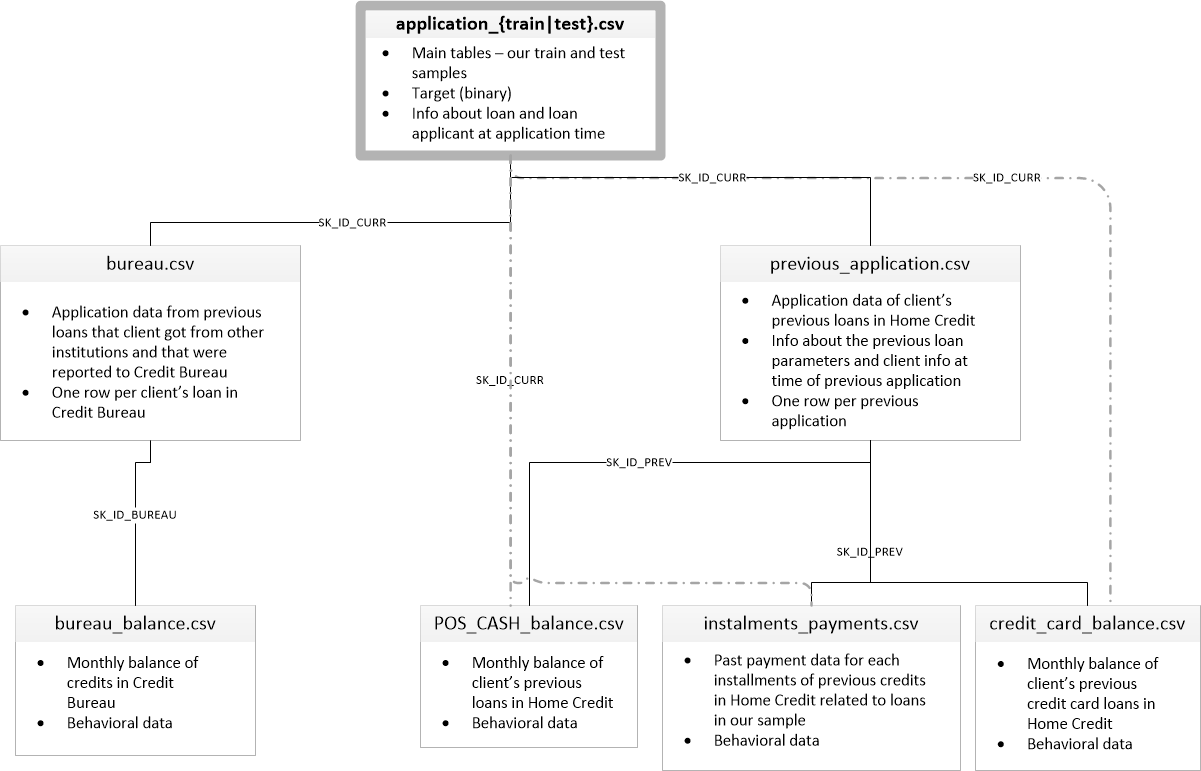

Moreover, we are provided with the definitions of all the columns (in HomeCredit_columns_description.csv) and an example of the expected submission file.

In this notebook, we will stick to using only the main application training and testing data. Although if we want to have any hope of seriously competing, we need to use all the data, for now we will stick to one file which should be more manageable. This will let us establish a baseline that we can then improve upon. With these projects, it's best to build up an understanding of the problem a little at a time rather than diving all the way in and getting completely lost!

## Metric: ROC AUC
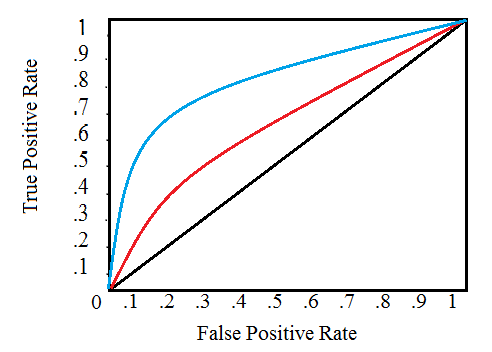



ROC곡선과 AUC스토어 > 이진 분류 예측 성능 측정에서의 중요 지표.

* ROC 곡선: FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate,  재현율)이 어떻게 변하는지를 나타내는 곡선
* 임계값을 1부터 0까지 변화시키면서 FPR을 구하고 이 FPR 값의 변화에 따른 TPR값을 구하는 것
* 가운데(ROC곡선의 최저 값)
> ROC 곡선이 직선에 멀어질수록 성능이 뛰어남

* AUC : ROC곡선 밑의 면적
> 1에 가까울수록 좋은 수치 

* 불균형 자료 > 정확도보다 ROC AUC, F1 

### Imports 
We are using a typical data science stak: numpy, pandas, sklearn, matplotlib.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

## Read in Data
First, we can list all the available data files. There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the tareget), 1 example submission file, and 6 other files containing additional information about each loan.

- test, train main 1개, 그 외는 추가 정보

In [ ]:
app_train = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
print('Training data shape : ', app_train.shape)
app_train.head()

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the **TARGET** ( the label we want to predict).

In [ ]:
# Testing Data features
app_test = pd.read_csv('../input/home-credit-default-risk/application_test.csv')
print('Testing data shape:', app_test.shape)
app_test.head()

The test set is considerably smaller and lacks a TARGET column.

# Exploratory Data Analysis(EDA)

EDA is an open-ended process where we calculate statistics and make figures to find trends(추세), anomalies(이상징후), patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or thy can be used to inform our modeling choices, such as by helping us decide which features to use.


## 1) Examine the Distribution of the Target Column
The target is what we are asked to predict: either a 0 for the loan was reapaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [ ]:
app_train['TARGET'].value_counts()

In [ ]:
app_train['TARGET'].astype(int).plot.hist()

From this information, we see this is an imbalanced class problem. There are far mor loans that were repain on time than loans than ere not repaid. Once we get into more sophisticated machine learning models, we can weight the calsses by their representation in the data to reflect this imbalance.(가중치 부여)

## 2) Examine Missing Values
Next we can look at the number and percentage of missing values in each column. 

In [ ]:
# function to calculate missing values by column
def missing_values_table(df):
    mis_val = df.isnull().sum()
    
    # Percentage of missing valeus
    mis_val_percent = 100* df.isnull().sum() / len(df)
    
    # make a table 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename
    mis_val_table_ren_columns = mis_val_table.rename( columns = {
        0 : 'Missing Valeus', 1 :'% of Total Values'
    })
    
    # Sort
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] !=0].sort_values(
    '% of Total Values', ascending = False).round(1)
    
    # Print 
    print('Your selected dataframe has ' + str(df.shape[1]) + ' coumns. \n'
         "There are " + str(mis_val_table_ren_columns.shape[0]) +
         'columns that have missing values')
    
    # Return
    return mis_val_table_ren_columns

In [ ]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

When it comes time to build our machine learning models, we will have to fill in these missing values(known as imputation). In later work, we will use models such as **XGBoost that can handle missing values with no need for imputation**. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

* XGBoost - 과적합 문제 심각할 시
* eta, max_depth↓, min_child_weight, gamma ↑, subsaple, colsample_bytree 조정 

## 3) Column Types

Let's look at the number of columns of each data type. int64 and float 64 are numeric variables(which can be either discrete or continuous). object columns contain strings and are categorical features.

In [ ]:
# Number of each type of column
app_train.dtypes.value_counts()

Let's now look at the number of unique entries in each of the object (categorical) columns.

In [ ]:
# object
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables!

## 4) Encoding Categorical Variables
Before we go any further, we need to deal with pesky(성가신) categorical variables. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as **LightGBM**). 
Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below
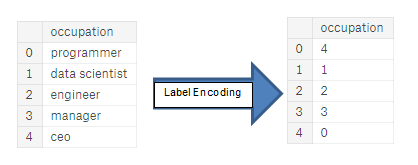

* One-hot encoding : create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.
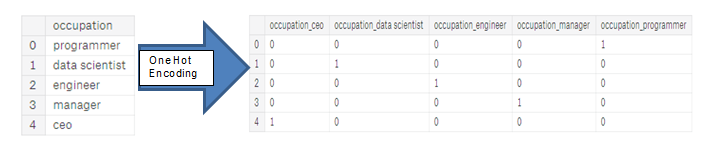

The problem with label encoding is that it gives the categoris an arbitary ordering(임의로 순서).
 The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. (예시 설명) then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option. 
 
 The only downside to one-hot encoding is that the number of features (dimensions of the data) **can explode with categorical variables with many categories.** To deal with this, we can perform one-hot encoding followed by PCA or other dimensionality reduction methods to reduce the number of dimensions (while still trying to preserve information).
 
 - 범주 2개 > label encoding, use Scikit-Learn LabelEncoder
 - 범주 2개 이상 > one-hot encoding, use pandas get_dummies(df)

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <=2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            le_count +=1
print('%d columns were label encoded.' % le_count)

In [ ]:
# one-hot encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shpae:', app_train.shape)
print('Testing Features shpae:', app_test.shape)

## 5) Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set axis = 1 to align the dataframes based on the columns and not on the rows!

- same feature(columns) 만들기 
- test에 없는 train data remove
- target data 추출 후 align

In [ ]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try dimensionality reduction (removing features that are not relevant) to reduce the size of the datasets.

## 6) Back to EDA

### 6-1) Anomalies(이상치)

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to **mis-typed numbers, errors in measuring equipment,** or they could be **valid but extreme measurements**. One way to support anomalies quantitatively is by **looking at the statistics of a column using the describe method**. The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:
- 이상치 확인 > 열의 통계 확인(describe())

In [ ]:
app_train['DAYS_BIRTH'].describe()

In [ ]:
(app_train['DAYS_BIRTH'] / -365).describe()

Those ages look reasonable. There are no outlier for the age on either the high or low end. How about the days of employment?

In [ ]:
app_train['DAYS_EMPLOYED'].describe()

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

In [ ]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [ ]:
# DAYS_EMPLOYED max = 365243
anom = app_train[app_train['DAYS_EMPLOYED'] ==365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

print('The non-anomalies defalut on %0.2f%% of loans' %(100* non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))
# default > 채무 불이행
# non-anomalies 8.66% 대출채무불이행, anomalies - 5.4% 대출 채무불이행

Well that is extremely interesting! It turns out that the anomalies have a **lower rate of default.**

Handling the anomalies depends on the exact situation, with no set rules.  
One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machinelearning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number(np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

- anomalies는 상황에 따라 설정하나 가장 안전한 접근은 결측값으로 만드는 
- 이 경우, 같은 값을 갖고 있기에 same value 지정 
- 결론적으로 np.nan로 채워준 뒤 새로운 boolean 칼럼을 만들어 이상값인지 아닌지 구분할 것

In [ ]:
# Create an anomalous flag column
# 이상치(365243)인 값에 대해 T,F로 구분
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243

# Replace nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (because we will have to fill in the nans with some value, probably the median of the column). The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

As an extemely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with np.nan in the testing data.

- 분포가 예상하는 바와 일치(?) = 값이 이상치?
- test data에도 적용

In [ ]:
app_test['DAYS_EMPLOYED_ANOM']=app_test['DAYS_EMPLOYED']==365243
app_test['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)

# True, False로 되어있는 데이터 sum > True인것 개수 카운팅
print('There are %d anomalies in the test data out of %d entries'%(app_test['DAYS_EMPLOYED_ANOM'].sum(), len(app_test)))

### 6-2) Correlations
Now, that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between and features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the **.corr** dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absoulte value of the correlation coefficent are:


* .00-.19 “very weak”
* .20-.39 “weak”
* .40-.59 “moderate”
* .60-.79 “strong”
* .80-1.0 “very strong

In [ ]:
# 상관관계 찾기, sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Let's take a look at some of more significant correlations:
the DAYS_BIRTH is the most positive correlation. (except for TARGET because the correlation of a variable with itself is always 1) Looking at the documentation, DAYS_BRITH is the age in days of the client at the time of the loan in begative days(for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0) That's a little confusing, so we will take the absoulte value of the feature and then the correlation will be negative.

- DAYS_BIRTH 가장 양의 상관성이 높다. 양의 상관이지만 실제 값들은 음수다
- 고객 나이가 많을수록 대출 상환할 가능성이 적다(??) 라는 해석이 나오는데 값이 음수여서 그렇게 나타난 것
- 절댓값을 취해 다시 상관관계를 본다.

### 6-3) Effect of Age on Repayment

In [ ]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

- 고객 나이 많을수록 대출 상환할 가능성 높음

In [ ]:
plt.style.use('fivethirtyeight')

plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor='k',bins= 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as the ages are reasonable.
To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (It is created by computing a kernel, usually a Gaussian, at each data point then averaging all the individual kernels to develope a single smooth curve). We will use the seaborn kdelplot for this graph.
- 분포 고르다. 나이별 특이점 없음
- 커널밀도그래프를 통해 target에 따른 나이대별 분포 확인 

Density Estimation(밀도 추정) : 어떤 변수가 가질 수 있는 값 및 그 값을 가질 가능성의 정도를 추정하는 것

히스토그램은 bin에 따라 불연속이 발생하기에 histogram 확률 밀도 함수를 smooth(평활)한 KDE가 필요

In [ ]:
plt.figure(figsize=(10,8))

# repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH']/365, label = 'target == 0')

# not repaid
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target ==1 curve skews towards the younger end of the range.
Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

- 대출 상환이 어려운(target ==1) 곡선이 younger 쪽에 몰려 있음
- 상관계수가 -0.07이기에 유의미한 값은 아니나 목표값에 영향을 주기에 유용
- 평균 연령 계층별(5년단위) 대출 상황 실패 그래프 만들기

In [ ]:
# Age 정보
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20,70,num=11))
age_data.head(10)

# np.linspace(start, stop, num):숫자로 된 시퀀스 생성
# YEAR_BIRTH - min 20,max 70

In [ ]:
# Group by the bin and calculate averages
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

In [ ]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot

# str, number만 가능하므로 str로 변환
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

- 젊을수록 대출금을 상환하지 않을 가능성 높다
- 가장 younger 세 연령대 10%, 가장 older 세 연령대 5% 미만
- 젊은층에게 더 많은 지침, 재정 계획 팁을 제공해야함(제때 돈을 지불 할 예방조치)

### 6-4) Exterior Sources

The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source".  I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data. 

Let's take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize = (8,6))

# Heatmap
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
# annot : 각 셀 값 표시 여부, cmap = color
plt.title('Correlation Heatmap');

All three EXT_SOURCE featureshave negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

- EXT_SOURCE는 모두 TARGET과 음의 상관관계
- EXT_SOURCE가 증가할수록 대출 상환 가능성 높다(TARGET=0에 가까이)
- DAYS_BIRTH와 EXT_SOURCE_1은 양의 상관성이 높은데 이는 client age와 관련이 있을 가능성이 있다.



In [ ]:
# 각 EXT_SOURCE를 TARGET별로 분포 파악

plt.figure(figsize = (10,12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3,1, i+1)
    
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET']==0, source], label = 'target==0')
    
    # plot not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET']==1, source], label = 'target==1')
    
    # label
    plt.title('Distribution of %s by TARGET Value' % source)
    plt.xlabel('%s'% source); plt.ylabel('Density');
    plt.tight_layout(h_pad = 2.5)
    # tight_layout : 여백 설정, h_pad : 높이의 여백

EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

- EXT_SOURCE_3가 target 0,1의 차이가 가장 큼 > 관련성 O

### 6-5) Pairs Plot
As a final exploratory plot, we can make a pairs plot of the EXT_SOURCE variables and the DAYS_BIRTH variable. The Pairs Plot is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

If you don't understand this code, that's all right! Plotting in Python can be overly complex, and for anything beyond the simplest graphs, I usually find an existing implementation and adapt the code (don't repeat yourself)!

- EXT_SOURCE 와 DAYS_BIRTH 변수간의 pair plot
- 각각의 분포와 여러 변수 간의 관계도 보여줌

In [ ]:
# copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
# 질문 ) limit 이유
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
# **kwargs : 이름이 지정된 인자를 처리할 때 
# 질문 ) **kwargs를 왜 사용하는가
# 함수 사용 이유
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)
    

# Create the pairgrid object
# vars > 변수명 리스트
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the EXT_SOURCE_1 and the DAYS_BIRTH (or equivalently YEARS_BIRTH), indicating that this feature may take into account the age of the client.

- 빨간선 : 상환되지 않은 대출
- 파란선 : 상환된 대출
- EXT_SOURCE_1과 DAY_BIRTH 중간 정도의 양의 선형관계
- 고객의 연령 고려

## 7) Feature Engineering

Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on gradient boosting). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparmeter tuning. 

While choosing the right model and optimal settings are important, the model can only learn fromthe data it is given. MAking sure this data is as relevant to the task as possible is the job of DS(and maybe some automated tools to help us out).

Feature engineering refers to a general process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only th most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

We will do a lot of feature engineering when we start using the other data sources, but in this notebook we will try only two simple feature construction methods:

**1) Polynomial features**

**2) Domain knowledge features**

- kaggle competition은 feature engineering(유의미한 feature찾기) 중요
> GBM : 여러 개의 약한 학습기를 순차적으로 학습-예측하며 잘못 예측한 데이터에 가중치 부여(경사하강법)를 통해 오류를 개선해 나가며 학습하는 방식.
- feature engineering >>> 모델 구축, 하이퍼 튜닝
- feature construction(new feature추가, feature 선택, 차원 축소)
- 여기서, Polynomial features, Domain knowledge features 방법 사용

### 7-1) Polynomial Features


One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables EXT_SOURCE_1^2 and EXT_SOURCE_2^2 and also variables such as EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, EXT_SOURCE_1^2 x EXT_SOURCE_2^2, and so on. These features that are a combination of multiple individual variables are called interaction terms because they capture the interactions between variables. In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. Interaction terms are commonly used in statistical models to capture the effects of multiple variables, but I do not see them used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan.


In the following code, we create polynomial features using the EXT_SOURCE variables and the DAYS_BIRTH variable. Scikit-Learn has a useful class called PolynomialFeatures that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into problems with overfitting).

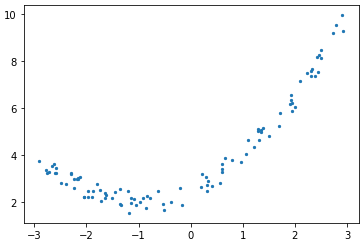

- 곡선 형태를 띄는 데이터는 일반적인 선형회귀로 해결할 수 없다.(비선형)
- 데이터들간의 형태가 비선형 일때 데이터에 각 특성의 제곱(세제곱)을 추가해주어서 특성이 추가된 비선형 데이터를 선형 회귀 모델로 훈련시키는 방법이다. > 일차방정식이 되도록

--- 
- 어떤 변수 각각은 target에 영향을 미치지 않을 수 있지만, 두 변수를 결합하면 target에 영향을 미칠 수 있음

- EXT_SOURCE, DAYS_BIRTH(단항 계수)를 이용해 polynomial feature 생성(3차 다항계수)
- 차수가 높아질수록 과적합 문제 발생

In [ ]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# 결측치 처리를 위해 imputer 호출
# SimpleImputer로 업데이트
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# target값 따로 저장
poly_target=poly_features['TARGET']
# target값 제외한 나머지 변수 저장 
poly_features=poly_features.drop(columns=['TARGET'])

# train > fit_transform, test > transform
poly_features=imputer.fit_transform(poly_features)
poly_features_test=imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [ ]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

This creates a considerable number of new features. To get the names we have to use the polynomial features get_feature_names method

In [ ]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

- 35개 feature 생성, new feature가 target과 상관관계가 있는지 확인해보자

In [ ]:
# Create a dataframe of the features
poly_features = pd.DataFrame(poly_features, columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))


In [ ]:
ext_data_corrs
# original corr
# TARGET변수와 상관관계가 가장 높은 EXT_SOURCE_3 > -0.1789
# EXT_SOURCE_2 EXT_SOURCE_3 조합 > -0.19로 더 큼

Several of the new variables have a greater (in terms of absoulte magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and ten evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

- original 보다 new feature가 더 큰 상관관계를 가짐
- 해당 feature가 있는 모델과 없는 모델로 효과가 있는지 평가

In [ ]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

### 7-2) Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but the perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whethere a client will default on a loan. Here I'm going to **use five features** that were inspired by Aguiar:

- CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
- 소득 대비 amount credit 

- ANNUITY_INCOME_PERCENT: the percentage of the loan annuity(연금) relative to a client's income
- 소득 대비 연금 대출 

- CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due)
- 월별 payment

- DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age
- 연령 대비 고용일수

In [ ]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']

app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']

app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']

app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [ ]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']

app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']

app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']

app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

**Visualize New Variables**

We should explore these domain knowledge variables visually in a graph.

For all of these, we will make the same KDE plot colored by the value of the TARGET

- domain 기반 새로만든 변수 시각화 하기 > KDE

In [ ]:
plt.figure(figsize = (12,20))

# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    plt.subplot(4,1, i+1)
    
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out!

- target간 차이가 없음. test 필요

**Baseline**

For a naive baseline, we could guess the same value for all examples on the testing set. We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition (random guessing on a classification task will score a 0.5).

Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.

- 대출을 갚지 못할 확률 예측하고자 한다.
- 확신할 수 없다면, test set의 모든 관측치에 0.5라고 예측
- AUC ROC 기본 값 0.5로 나옴


베이즈 정리 : feature 끼리 서로 독립 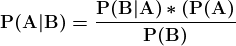



## 8) Logistic Regression Implementation

Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms, I recommend both An Introduction to Statistical Learning and Hands-On Machine Learning with Scikit-Learn and TensorFlow. Both of these books present the theory and also the code needed to make the models (in R and Python respectively). They both teach with the mindset that the best way to learn is by doing, and they are very effective!

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

- baseline을 얻기 위해, 범주형 변수 인코딩 후 모든 featrue 사용
- 결측값 입력(imputation) > 정규화(feature scaling)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# training 데이터에서 TARGET 변수 drop -> TARGET변수는 결측치처리 및 Scaling대상아니기때문에
if 'TARGET' in app_train:
    train=app_train.drop(columns=['TARGET'])
else:
    train=app_train.copy()

# 변수이름
features=list(train.columns)

# testing 데이터 복사
test=app_test.copy()

# 결측치를 median값으로 처리
imputer = SimpleImputer(strategy='median')

'''
각 Feature의 값을 일정한 범위 또는 규칙에 따르게 하기 위해서 스케일링을 사용
'''
# 각각의 변수를 0~1 사이의 값으로 만들어주는 MinMaxScaler 사용
## MinMaxScaler 클래스의 인스턴스를 만들어준다
scaler=MinMaxScaler(feature_range=(0,1))

# training 데이터에 fit
imputer.fit(train)

# training데이터와 testing데이터에 둘다 transform
## imputer 처리 하고나면 DataFrame에서 array형태로 바뀜
train=imputer.transform(train)
test=imputer.transform(test)

# Scaling
scaler.fit(train)
train=scaler.transform(train)
test=scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

We will use LogisticRegressionfrom Scikit-Learn for our first model. The only change we will make from the default model settings is to lower the regularization parameter, C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default LogisticRegression, but it still will set a low bar for any future models.

Here we use the familiar Scikit-Learn modeling syntax: we first create the model, then we train the model using .fit and then we make predictions on the testing data using .predict_proba (remember that we want probabilities and not a 0 or 1).

- 로지스틱 회귀 분석 사용
- regularization 파라미터 C 낮추기: 과적합 방지
- log_reg로 모델 생성 > 모델 훈련: fit() > 예측: .predict_proba()

In [ ]:
from sklearn.linear_model import LogisticRegression

# 모델 생성 with specified reqularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train
log_reg.fit(train, train_labels)

Now that the model has been trained, we can use it to make predictions. We want to predict the probabilities of not paying a loan, so we use the model predict.proba method. This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

The following code makes the predictions and selects the correct column.


- 모델 train후 예측 값은 m x 2 배열로 나오는데 (m: 관측치 개수), 첫번째 컬럼은 0일 확률 두번째 컬럼은 1일 확률이다. 
- 두 컬럼의 합은 1이 되어야 함

- 대출 상환하지 못할 확률인 target 1을 (second) 선택 해야함.

In [ ]:
# make predictions
# make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:,1]

The predictions must be in the format shown in the sample_submission.csv file, where there are only two columns: SK_ID_CURR and TARGET. We will create a dataframe in this format from the test set and the predictions called submit.

- arrary > dataframe 형식으로 만들기(SK_ID_CURR 추가)


In [ ]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

The predictions represent a probability between 0 and 1 that the loan will not be repaid. If we were using these predictions to classify applicants, we could set a probability threshold for determining that a loan is risky.

- 대출 상환하지 못할 확률 0에서 1
- 대출이 위험하다고 판단하기 위한 threshold(임계값) 설정 가능

In [ ]:
# Save the submission to a csv file
submit.to_csv('log_reg_baseline.csv', index = False)

The logistic regression baseline should score around 0.671 when submitted.


## 9) Improved Model: Random Forest
To try and beat the poor performance of our baseline, we can update the algorithm. Let's try using a Random Forest on the same training data to see how that affects performance. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.

- baseline 개선 > Random Forest 적용(성능 더 좋음)
- 100 tree 사용
----
bagging : 같은 알고리즘으로 여러 개의 분류기를 만들어 voting으로 최종 결정


**Random Forset**
- bootstrapping 분할 방식(배깅) 사용: 개별 트리가 학습하는 데이터 세트는 전체 데이터에서 일부 중첩되게 샘플링된 데이터 세트

- tree 기반 단점(과적합) 개선

- n_estimators : 결정 트리 갯수 지정, default=10 
> 갯수를 늘릴수록 시간이 오래걸리며 무조건 성능이 좋아지는 것만은 아님. 
- random_state : 고정해야함
- n_jobs : 적합성과 예측성을 위해 병렬로 실행할 작업 수
> n_jobs=-1: 컴퓨터의 모든 코어 사용

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# train
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# make predictions on the test data
predictions = random_forest.predict_proba(test)[:,1]

In [ ]:
# make submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

This model should score around **0.678** when submitted.

### 9-1) Make Predictions using Engineered Features
The only way to see if the Polynomial Features and Domain knowledge improved the model is to train a test a model on these features! We can then compare the submission performance to that for the model without these features to gauge the effect of our feature engineering.
- feature engineering(Polynomial / Domain) 기반 예측
- 기존 train 변수에 다항 변수 추가한 app_train_poly가 아닌, 다항 변수만 있는 poly_features로 예측

In [ ]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = SimpleImputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)
# 질문 ) poly_features 만 추출??

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# training data에 훈련시키기
random_forest_poly.fit(poly_features, train_labels)

# test데이터로 예측
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

In [ ]:
submit=app_test[['SK_ID_CURR']]
submit['TARGET']=predictions

submit.to_csv('random_forest_baseline_engineered.csv',index=False)

This model scored **0.678** when submitted to the competition, exactly the same as that without the engineered features. Given these results, it does not appear that our feature construction helped in this case.

- poly_feature 결과가 전체 예측 결과와 크게 다르지 않음
- polynomial 방식이 효과가 없었음


**Testing Domain Features**

Now we can test the domain features we made by hand.

In [ ]:
app_train_domain.head()

In [ ]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = SimpleImputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

In [ ]:
submit=app_test[['SK_ID_CURR']]
submit['TARGET']=predictions

submit.to_csv('random_forest_baseline_domain.csv',index=False)

This scores 0.679 when submitted which probably shows that the engineered features do not help in this model (however they do help in the Gradient Boosting Model at the end of the notebook).

- domain 변수 또한 모델에 큰 도움을 주지 못함

## 10) Model Interpretation: Feature Importances
As a simple method to see which variables are the most relevant, we can look at the feature importances of the random forest. Given the correlations we saw in the exploratory data analysis, we should expect that the most important features are the EXT_SOURCE and the DAYS_BIRTH. We may use these feature importances as a method of dimensionality reduction in future work.

- random forest로 feature 중요도 파악
- 나중에, feature importances를 사용해 차원 축소

In [ ]:
def plot_feature_importances(df):
    '''
    feature 중요도 높은 순으로 나열
    
    인수(Args) : df(dataframe) : feature importances
    
    반환(Return): 15개 feature

    '''
    
    # 중요도 순서로 나열
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # 정규화 ( 해당 feature 중요도 / 전체 중요도의 합)
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    # 시각화
    plt.figure(figsize=(10,6))
    ax=plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:15]))), df['importance_normalized'].head(15), align='center',edgecolor='k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df
    

In [ ]:
feature_importances_sorted = plot_feature_importances(feature_importances)

As expected, the most important features are those dealing with EXT_SOURCE and DAYS_BIRTH. WE see that there are noly a handful of features with a significant importance to the model, which suggests we may be able to drop many of the features without a decrease in performance (and we may even see an increase in performance.) Feature importances are not the most sophisticated method to interpret a model or perform dimensionality reduction, but they let us start to understand what factors our model takes into account when it makes predictions.

- 중요 : EXT_SOURCE and DAYS_BIRTH
- model에는 중요한 일부 feature만 존재 
- feature importance > 예측 시 model이 고려하는 요소 파악

In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

We see that all four of our hand-engineered features made it into the top 15 most important! This should give us confidence that our domain knowledge was at least partially on track.

- domain 기반으로 만든 4개의 변수가 변수 중요도 top 15에 포함

## 11) Conculsion
domain기반으로 만든 변수를 모델에 포함 했을 때 score가 가장 좋다.